# TLDR
Given a camera's physical characteristics, predict lens distortion parameters.


# Data directory and globals

In [2]:
from pathlib import Path

basedir = Path('g:/My Drive/Projects/camflex/')

# Define the directory containing the lens data
lensdatadir = basedir / 'data'

# Define the output CSV file path
output_csv_path = basedir / 'training_data.csv'

# Define model_dir
model_dir = basedir / 'models'

import numpy as np
# Set seeds for reproducibility
np.random.seed(42)

In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

# Mount Google Drive locally

In [ ]:
%%skip
from google.colab import drive
drive.mount('/content/drive')
lensdatadir = Path('/content/drive/My Drive/Projects/camflex/data')
%pip install onnxmltools onnxconverter_common

# Test if we can see `lensdatadir`

In [ ]:
# prompt: test if directory exists

import os

def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  return os.path.isdir(path)

# Example usage:

if directory_exists(lensdatadir):
  print(f"Directory '{lensdatadir}' exists.")
else:
  print(f"Directory '{lensdatadir}' does not exist.")

# Convert 3DE JSON to CSV

In [ ]:
from pathlib import Path

camera_resolutions = {
    'Alexa35_3.3k_6x5': (3328, 2790),
    'Alexa35_HD': (1920, 1080),
    'Alexa35_OG': (4608, 3164),
    'Alexa65_6.5k_OG': (6560, 3100),
    'AlexaLF_HD': (1920, 1080),
    'AlexaLF_OG': (4448, 3096),
    'AlexaMini_OG': (3424, 2202),
    'AlexaSXT_2.8k': (2880, 2160),
    'PANAVISION_DXL2_4k_FF': (4096, 2160),
    'PANAVISION_DXL2_6k_HD': (5760, 3240),
    'PANAVISION_DXL2_8k_OG': (8192, 4320),
    'PANAVISION_DXL_6.5k_HD': (6144, 3456),
    'RED_Dragon_4k_HD': (3840, 2160),
    'RED_Dragon_FF': (6144, 3160),
    'RED_Mysteriumx_S35_5k_2x1': (5120, 2560),
    'RED_MysteriumX_S35_5k_3x2': (5120, 2560),
    'RED_MysteriumX_S35_5k': (5120, 2560),
    'RED_WeaponS35_4.5k_HD': (4320, 2376),
    'RED_WeaponS35_5.5k_FF': (5632, 2948),
    'RED_WeaponS35_8k_FF': (6144, 3160),
    'SONY_F55': (4096, 2160),
    'SONY_F65': (4096, 2160),
    'SONY_Venice2_3x2_FF': (8640, 5760),
    'SONY_Venice2_FF_3x2': (8640, 5760),
    'SONY_Venice2_5.8k_6x5': (5792, 4854)
}

def extract_lens_and_camera(path, camera_resolutions):
    path_parts = Path(path).parts  # Use pathlib to get the path components
    if "data" in path_parts:
        data_index = path_parts.index("data")
        if data_index + 2 < len(path_parts):
            lens_name = path_parts[data_index + 2]
            
            # Extract camera name from the filename
            file_name = Path(path).name
            if 'mm__' in file_name and file_name.endswith('.json'):
                camera_name = file_name.split('mm__')[1].split('.json')[0].lstrip('_')
                
                # Check if the camera_name is in the camera_resolutions dictionary
                if camera_name not in camera_resolutions:
                    raise ValueError(f"Camera '{camera_name}' not found in camera_resolutions.")
                
                # Handle special cases
                if camera_name == 'SONY_Venice2_3x2_FF':
                    camera_name = 'SONY_Venice2_FF_3x2'
    
                if camera_name == 'RED_Mysteriumx_S35_5k_2x1' or camera_name == 'RED_MysteriumX_S35_5k_3x2':
                    camera_name = 'RED_MysteriumX_S35_5k'

                return lens_name, camera_name
    return None, None

# Example usage
path = Path(r"G:\My Drive\Projects\camflex\data\ZEISS_CP3\ZEISS_CP3_018mm\lens_flame__ZEISS_CP3_018mm__Alexa35_3.3k_6x5.json")
lens_name, camera_name = extract_lens_and_camera(path, camera_resolutions)
print(f"Lens Name: {lens_name}, Camera Name: {camera_name}")

In [ ]:
import os
import json
import csv

def extract_lens_name(input_string):
    return input_string.rpartition('_')[-1].lstrip('0')

def convert_json_to_csv(json_file_path):
    lens_name, camera_name = extract_lens_and_camera(json_file_path, camera_resolutions)
    
    pixel_width, pixel_height = camera_resolutions[camera_name]

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Extract necessary data
    lens_params = data["AutodeskFlame3DELensDistortion"]["LensParams"]
    focus_distances = data["AutodeskFlame3DELensDistortion"]["FocusDistance"]
    model_params = data["AutodeskFlame3DELensDistortion"]["ModelParams"]
    focal_length = data["AutodeskFlame3DELensDistortion"]["FocalLength"]

    sensor_width = lens_params.get("FBackWidth", None)
    sensor_height = lens_params.get("FBackHeight", None)

    # Filter out distances greater than 500000
    filtered_distances = [d for d in focus_distances if d <= 500000]

    # Prepare data for CSV
    csv_data = []

    for i, distance in enumerate(filtered_distances):
        row = {
            "Distance": distance,

            "K1": model_params["Distortion - Degree 2"][i] if i < len(model_params["Distortion - Degree 2"]) else None,
            "K2": model_params["Quartic Distortion - Degree 4"][i] if i < len(model_params["Quartic Distortion - Degree 4"]) else None,
            
            "U2": model_params["U - Degree 2"][i] if i < len(model_params["U - Degree 2"]) else None,
            "U4": model_params["U - Degree 4"][i] if i < len(model_params["U - Degree 4"]) else None,
            "V2": model_params["V - Degree 2"][i] if i < len(model_params["V - Degree 2"]) else None,
            "V4": model_params["V - Degree 4"][i] if i < len(model_params["V - Degree 4"]) else None,
            
            "SensorW": sensor_width,
            "SensorH": sensor_height,
            "FocalLength": focal_length[0] if isinstance(focal_length, list) and focal_length else None,
            "LensName": lens_name,  # Add lens_name as a column
            "CameraName": camera_name,  # Add camera_name as a column
            "PixelWidth": pixel_width,
            "PixelHeight": pixel_height
        }
        csv_data.append(row)

    # Remove the last row
    if csv_data:
        csv_data.pop()

    # Write to CSV
    csv_file_name = os.path.splitext(os.path.basename(json_file_path))[0] + '.csv'
    csv_file_path = os.path.join(os.path.dirname(json_file_path), csv_file_name)
    csv_headers = ["Distance", "K1", "K2", "U2", "U4", "V2", "V4", "SensorW", "SensorH", "FocalLength", "LensName", "CameraName", "PixelWidth", "PixelHeight"]

    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        writer.writeheader()
        writer.writerows(csv_data)

    print(f"Data successfully written to {csv_file_path}")


In [ ]:
from pathlib import Path

# Main function to process all JSON files in a directory recursively
def process_directory(input_dir):
    input_path = Path(input_dir)
    for json_file_path in input_path.rglob("*.json"):
        #print(json_file_path.parent, json_file_path.name)
        convert_json_to_csv(json_file_path)

process_directory(lensdatadir)

# Extract the data from the CSV files 🔢

In [ ]:
import pandas as pd
from pathlib import Path

# Function to get CSV files in a directory recursively
def get_csv_files(path):
    dir_path = Path(path)
    return [item for item in dir_path.rglob('*.csv')] if dir_path.exists() and dir_path.is_dir() else []

# Function to extract columns and remove rows with missing data
def extract_and_filter_csv_files(path):
    csv_files = get_csv_files(path)
    all_data = []

    for csv_file in csv_files:
        try:
            # Read each CSV file
            df = pd.read_csv(csv_file)
            # Add filename without leading path or extension as a column
            df['filename'] = csv_file.stem
            # Filter out rows with missing data
            initial_row_count = len(df)
            filtered_df = df.dropna()
            rows_dropped = initial_row_count - len(filtered_df)
            if rows_dropped > 0:
                 print(f"Dropped {rows_dropped} rows from {csv_file.name}")
            all_data.append(filtered_df)
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")

    # Concatenate all filtered dataframes into a single dataframe
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()


In [ ]:
# Extract and filter CSV files
training_data = extract_and_filter_csv_files(lensdatadir)

if not training_data.empty:
    print("Training data:")
    print(training_data.head())
else:
    print("No valid data to process.")

if (training_data.isna().any().any()):
    print("There are missing values in the data.")
else:
    print("There are no missing values in the data.")

# Write the training data to the CSV file
training_data.to_csv(output_csv_path, index=False)

print(f"Training data successfully written to {output_csv_path}")

# Load existing training data

In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
training_data = pd.read_csv(output_csv_path)

# Display the first few rows of the DataFrame
print(training_data.head())

   Distance        K1        K2            U2        U4        V2        V4  \
0      24.0  0.065365 -0.024750  2.477708e-06 -0.000052  0.000100 -0.000130   
1      25.0  0.065464 -0.025015  3.525759e-07 -0.000050  0.000101 -0.000133   
2      26.0  0.065554 -0.025268 -1.661690e-06 -0.000048  0.000102 -0.000137   
3      27.0  0.065701 -0.025736 -5.717650e-06 -0.000044  0.000105 -0.000143   
4      28.0  0.065769 -0.026179 -4.374831e-06 -0.000049  0.000109 -0.000154   

    SensorW  SensorH  FocalLength                 LensName        CameraName  \
0  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
1  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
2  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
3  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
4  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   

   PixelWidth  PixelHeight                  

# Plot data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a global color palette for consistent colors across all figures
unique_camera_names_global = training_data['CameraName'].unique()
color_mapping = dict(zip(unique_camera_names_global, sns.color_palette("colorblind", len(unique_camera_names_global))))

# Open a PdfPages object to save figures
with PdfPages('lens_analysis.pdf') as pdf:
    lens_names = training_data['LensName'].unique()

    for lens_name in lens_names:
        plt.figure(figsize=(18, 12))  # Set figure size
        plt.suptitle(f'Data for Lens Name: {lens_name}', fontsize=14)

        # Filter data for the current lens name
        lens_data = training_data[training_data['LensName'] == lens_name]

        if lens_data.empty:
            continue  # Skip if no data for this lens

        # Distance vs K1
        plt.subplot(3, 2, 1)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='K1',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K1')
        plt.title('Distance vs K1')

        # Distance vs K2
        plt.subplot(3, 2, 2)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='K2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K2')
        plt.title('Distance vs K2')

        # Distance vs U2
        plt.subplot(3, 2, 3)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='U2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('U2')
        plt.title('Distance vs U2')

        # Distance vs V2
        plt.subplot(3, 2, 4)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='V2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('V2')
        plt.title('Distance vs V2')

        # Distance vs U4
        plt.subplot(3, 2, 5)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='U4',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('U4')
        plt.title('Distance vs U4')

        # Distance vs V4
        plt.subplot(3, 2, 6)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='V4',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('V4')
        plt.title('Distance vs V4')

        # Create a single legend for the figure
        handles = [plt.Line2D([0], [0], marker='o', color=color_mapping[camera], linestyle='', markersize=5) for camera in unique_camera_names_global]
        plt.figlegend(
            handles,
            unique_camera_names_global,
            title="Camera Name",
            loc='center left',
            bbox_to_anchor=(.85, 0.5),  # Adjust to position closer to the subplots
            borderaxespad=0,
        )

        # Adjust subplot spacing
        plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit legend
        plt.subplots_adjust(hspace=0.4, wspace=0.15)  # Reduce horizontal space (wspace)

        # Save the current figure to the PDF
        pdf.savefig()  # Save the current figure
        #plt.show() # Display the figure
        plt.close()  # Close the figure to free memory

    print("All figures have been saved to 'lens_analysis.pdf'")


# Visualize the parameter correlations

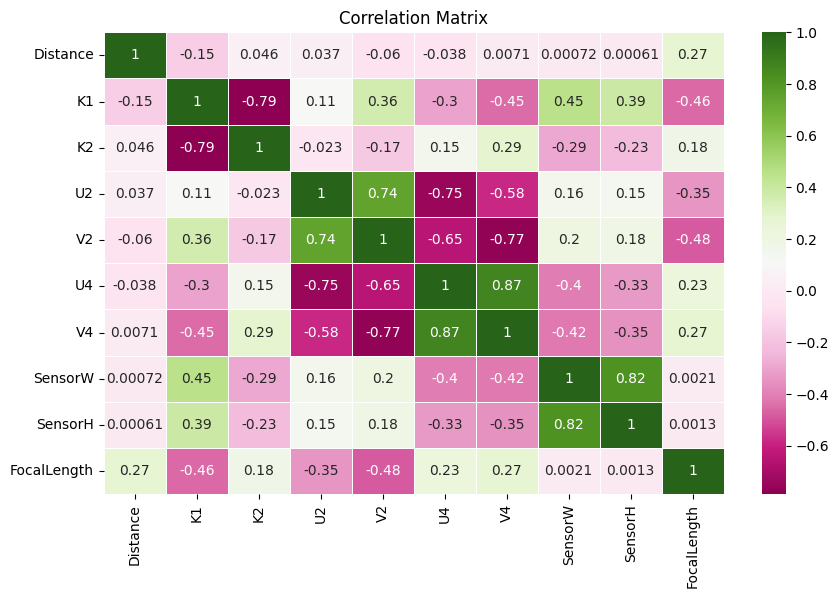

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix to check the relationships between the variables
corr_matrix = training_data[['Distance', 'K1', 'K2', 'U2', 'V2', 'U4', 'V4', 'SensorW', 'SensorH', 'FocalLength']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='PiYG', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Predict sensor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

# Load the dataset
file_path = output_csv_path
data = pd.read_csv(file_path)

# Defining features and targets
features = data[['Distance', 'K1', 'K2', 'FocalLength', 'U2', 'V2', 'U4', 'V4', 'PixelWidth', 'PixelHeight']]
target_w = data['SensorW']
target_h = data['SensorH']

# Splitting the data into training and testing sets
X_train, X_test, y_train_w, y_test_w = train_test_split(features, target_w, test_size=0.2, random_state=42)
_, _, y_train_h, y_test_h = train_test_split(features, target_h, test_size=0.2, random_state=42)

# Feature selection to prevent overfitting
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")
X_train_selected = selector.fit_transform(X_train, y_train_w)
X_test_selected = selector.transform(X_test)

# Hyperparameter tuning for SensorW
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_w.fit(X_train_selected, y_train_w)

best_model_w = grid_search_w.best_estimator_

# Evaluate using cross-validation
cv_scores_w = cross_val_score(best_model_w, X_train_selected, y_train_w, cv=5, scoring='r2')

# Train and predict for SensorW
best_model_w.fit(X_train_selected, y_train_w)
rf_predictions_w = best_model_w.predict(X_test_selected)

# Evaluate SensorW
rf_mse_w = mean_squared_error(y_test_w, rf_predictions_w)
rf_r2_w = r2_score(y_test_w, rf_predictions_w)
rf_mae_w = mean_absolute_error(y_test_w, rf_predictions_w)

# Repeat for SensorH
grid_search_h = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_h.fit(X_train_selected, y_train_h)

best_model_h = grid_search_h.best_estimator_
cv_scores_h = cross_val_score(best_model_h, X_train_selected, y_train_h, cv=5, scoring='r2')

best_model_h.fit(X_train_selected, y_train_h)
rf_predictions_h = best_model_h.predict(X_test_selected)

rf_mse_h = mean_squared_error(y_test_h, rf_predictions_h)
rf_r2_h = r2_score(y_test_h, rf_predictions_h)
rf_mae_h = mean_absolute_error(y_test_h, rf_predictions_h)

# Display evaluation metrics
print(f"SensorW - MSE: {rf_mse_w}, R2: {rf_r2_w}, MAE: {rf_mae_w}, CV R2: {cv_scores_w.mean()}")
print(f"SensorH - MSE: {rf_mse_h}, R2: {rf_r2_h}, MAE: {rf_mae_h}, CV R2: {cv_scores_h.mean()}")

# Plotting predictions vs actual values with metrics
plt.figure(figsize=(14, 6))
plt.suptitle("Random Forest Regressor: Actual vs Predicted", fontsize=16)

# SensorW plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_w, rf_predictions_w, alpha=0.6)
plt.plot([y_test_w.min(), y_test_w.max()], [y_test_w.min(), y_test_w.max()], 'r--')
plt.xlabel('Actual SensorW')
plt.ylabel('Predicted SensorW')
plt.title('Actual vs Predicted SensorW')

# Adding metrics to SensorW plot
plt.text(0.05, 0.95, 
         f"MSE: {rf_mse_w:.2f}\nMAE: {rf_mae_w:.2f}\nR²: {rf_r2_w:.2f}", 
         fontsize=10, 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# SensorH plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_h, rf_predictions_h, alpha=0.6)
plt.plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--')
plt.xlabel('Actual SensorH')
plt.ylabel('Predicted SensorH')
plt.title('Actual vs Predicted SensorH')

# Adding metrics to SensorH plot
plt.text(0.05, 0.95, 
         f"MSE: {rf_mse_h:.2f}\nMAE: {rf_mae_h:.2f}\nR²: {rf_r2_h:.2f}", 
         fontsize=10, 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import joblib

# Save the trained models
joblib.dump(best_model_w, "sensor_w_model.joblib")
joblib.dump(best_model_h, "sensor_h_model.joblib")

# Save the feature selector
joblib.dump(selector, "feature_selector.joblib")

print("Models and feature selector saved successfully.")


In [ ]:
# Load the models and feature selector
loaded_model_w = joblib.load("sensor_w_model.joblib")
loaded_model_h = joblib.load("sensor_h_model.joblib")
loaded_selector = joblib.load("feature_selector.joblib")

print("Models and feature selector loaded successfully.")

# Example usage with new data
new_data = pd.DataFrame({
    'Distance': [50],
    'K1': [0.1],
    'K2': [-0.2],
    'FocalLength': [35],
    'U2': [0.05],
    'V2': [0.1],
    'U4': [0.02],
    'V4': [0.03],
    'PixelWidth': [1920],
    'PixelHeight': [1080]
})

# Transform the new data using the loaded feature selector
new_data_selected = loaded_selector.transform(new_data)

# Predict SensorW and SensorH using the loaded models
predicted_sensor_w = loaded_model_w.predict(new_data_selected)
predicted_sensor_h = loaded_model_h.predict(new_data_selected)

# Display predictions
print(f"Predicted SensorW: {predicted_sensor_w[0]}")
print(f"Predicted SensorH: {predicted_sensor_h[0]}")


# Train, save and plot

In [10]:
# Remove these lenses because they have insufficient data
lenses_to_remove = ['ZEISS_Supreme_040mm', 'ZEISS_Supreme_065mm']

# Filter out the lenses from the training data
training_data = training_data[~training_data['LensName'].isin(lenses_to_remove)]

In [11]:
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

def save_xgboost_to_onnx(k1_model, k2_model, model_path, input_shape):
    """
    Convert separate XGBoost models for K1 and K2 to ONNX format and save them to disk.

    Parameters:
    - k1_model: The trained XGBoost model for K1.
    - k2_model: The trained XGBoost model for K2.
    - model_path: Path to save the ONNX model. Separate files will be created for each target.
    - input_shape: Number of features in the input data (integer).
    """
    if not isinstance(input_shape, int) or input_shape <= 0:
        raise ValueError(f"Invalid input_shape: {input_shape}. It must be a positive integer.")

    try:
        # Ensure feature names are compatible with ONNX format
        feature_names = [f"f{i}" for i in range(input_shape)]
        
        # Save K1 model
        k1_model.get_booster().feature_names = feature_names
        initial_type = [('float_input', FloatTensorType([None, input_shape]))]
        onnx_k1 = convert_xgboost(k1_model, initial_types=initial_type)
        k1_model_path = model_path.with_stem(model_path.stem + "_k1")
        with open(k1_model_path, "wb") as f:
            f.write(onnx_k1.SerializeToString())
        print(f"K1 ONNX model successfully saved at: {k1_model_path}")
        
        # Save K2 model
        k2_model.get_booster().feature_names = feature_names
        onnx_k2 = convert_xgboost(k2_model, initial_types=initial_type)
        k2_model_path = model_path.with_stem(model_path.stem + "_k2")
        with open(k2_model_path, "wb") as f:
            f.write(onnx_k2.SerializeToString())
        print(f"K2 ONNX model successfully saved at: {k2_model_path}")
    
    except Exception as e:
        print(f"Failed to convert XGBoost models to ONNX: {e}")
        raise


In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def train_separate_models(training_data):
    """
    Train separate XGBoost models for K1 and K2.

    Args:
        training_data (pd.DataFrame): DataFrame containing the features and targets.
            Expected columns: 'SensorW', 'SensorH', 'Distance', 'PixelWidth', 'PixelHeight', 'K1', 'K2'.

    Returns:
        tuple: Trained XGBoost models for K1 and K2, predictions, and test data (actual values).
    """
    # Rename features for compatibility
    feature_columns = ['SensorW', 'SensorH', 'Distance']
    renamed_features = {col: f"f{i}" for i, col in enumerate(feature_columns)}
    training_data = training_data.rename(columns=renamed_features)
    
    # Define features and targets
    features = training_data[list(renamed_features.values())]
    targets = training_data[['K1', 'K2']]
    
    # Split data into train-test
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    
    # Parameters for the models
    xgb_params = {
        'n_estimators': 200,
        'learning_rate': 0.1,
        'max_depth': 3,
        'min_child_weight': 3,
        'reg_alpha': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'rmse',
        'early_stopping_rounds': 10,
        'random_state': 42
    }
    
    # Train separate models for K1 and K2
    print("Training model for K1...")
    k1_model = xgb.XGBRegressor(**xgb_params)
    k1_model.fit(
        X_train, y_train['K1'],
        eval_set=[(X_test, y_test['K1'])],
        verbose=False
    )
    
    print("\nTraining model for K2...")
    k2_model = xgb.XGBRegressor(**xgb_params)
    k2_model.fit(
        X_train, y_train['K2'],
        eval_set=[(X_test, y_test['K2'])],
        verbose=False
    )
    
    # Make predictions
    predictions_k1 = k1_model.predict(X_test)
    predictions_k2 = k2_model.predict(X_test)
    
    # Combine predictions
    predictions = np.column_stack((predictions_k1, predictions_k2))
    
    return k1_model, k2_model, predictions, y_test


In [13]:
# Get all unique lens names
lens_names = training_data['LensName'].unique()

# Process specific lens for testing
#lens_names = ['ARRI-ZEISS_Master_100mm']
#lens_names = ['ARRIFLEX-ZEISS_MK_085mm']


# Store results for all lenses
lens_results = []

# Train and save models for each lens
for lens in lens_names:
    #lens_data = training_data[training_data['LensName'] == lens]
    lens_data = training_data[(training_data['LensName'] == lens) & (training_data['CameraName'] != 'Alexa35_3.3k_6x5')]

    
    # Train separate models for K1 and K2
    print(f"Training models for lens: {lens}")
    k1_model, k2_model, predictions, y_test = train_separate_models(lens_data)
    
    # Save the models to ONNX
    model_dir.mkdir(parents=True, exist_ok=True)  # Ensure the model directory exists
    save_xgboost_to_onnx(
        k1_model=k1_model,
        k2_model=k2_model,
        model_path=model_dir / f"{lens}_model.onnx",
        input_shape=3
    )
    
    # Store results for plotting
    lens_results.append((lens, y_test, predictions))


Training models for lens: ARRIFLEX-ZEISS_MK_018mm
Training model for K1...

Training model for K2...
K1 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_018mm_model_k1.onnx
K2 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_018mm_model_k2.onnx
Training models for lens: ARRIFLEX-ZEISS_MK_025mm
Training model for K1...

Training model for K2...
K1 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_025mm_model_k1.onnx
K2 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_025mm_model_k2.onnx
Training models for lens: ARRIFLEX-ZEISS_MK_035mm
Training model for K1...

Training model for K2...
K1 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_035mm_model_k1.onnx
K2 ONNX model successfully saved at: g:\My Drive\Projects\camflex\models\ARRIFLEX-ZEISS_MK_035mm_model_k2.onnx
Training models for lens: ARRIF

In [14]:
def plot_results(y_test, predictions, lens_name, r2_threshold=None):
    """
    Plot predictions vs actual values for K1 and K2.

    Args:
        y_test (pd.DataFrame): Actual test values for K1 and K2.
        predictions (np.ndarray): Predicted values for K1 and K2.
        lens_name (str): Name of the lens to include in plot titles.
        r2_threshold (float, optional): Plot only if R² < r2_threshold. Defaults to None.
    """
    # Calculate R² for both targets
    r2_values = []
    for idx, target in enumerate(['K1', 'K2']):
        actual = y_test[target]
        pred = predictions[:, idx]
        r2 = r2_score(actual, pred)
        r2_values.append(r2)

    # Skip the entire figure if R² threshold is not met for both targets
    if r2_threshold is not None and all(r2 >= r2_threshold for r2 in r2_values):
        #print(f"Skipping plot: All R² values ({r2_values}) are >= {r2_threshold}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    axes = axes.ravel()

    for idx, (target, label) in enumerate(zip(['K1', 'K2'], ['K1 Predictions', 'K2 Predictions'])):
        actual = y_test[target]
        pred = predictions[:, idx]

        mse = mean_squared_error(actual, pred)
        rmse = mse**0.5
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)

        # Set background color to dark orange if R² < 0.9
        if r2 < 0.9:
            axes[idx].set_facecolor('#878787')  # Dark orange (color-blind safe)

        dot_color = '#101010' if r2 < 0.9 else '#1D4990'

        # Scatter plot and perfect fit line
        axes[idx].scatter(actual, pred, alpha=0.7, label='Predictions', c=dot_color)
        axes[idx].plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='#A71B5F', lw=2, label='Perfect Fit')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f"{label}\nMSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        axes[idx].legend()
        axes[idx].grid()

    # Add overall title
    plt.suptitle(f"Predictions vs Actuals for Lens: {lens_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

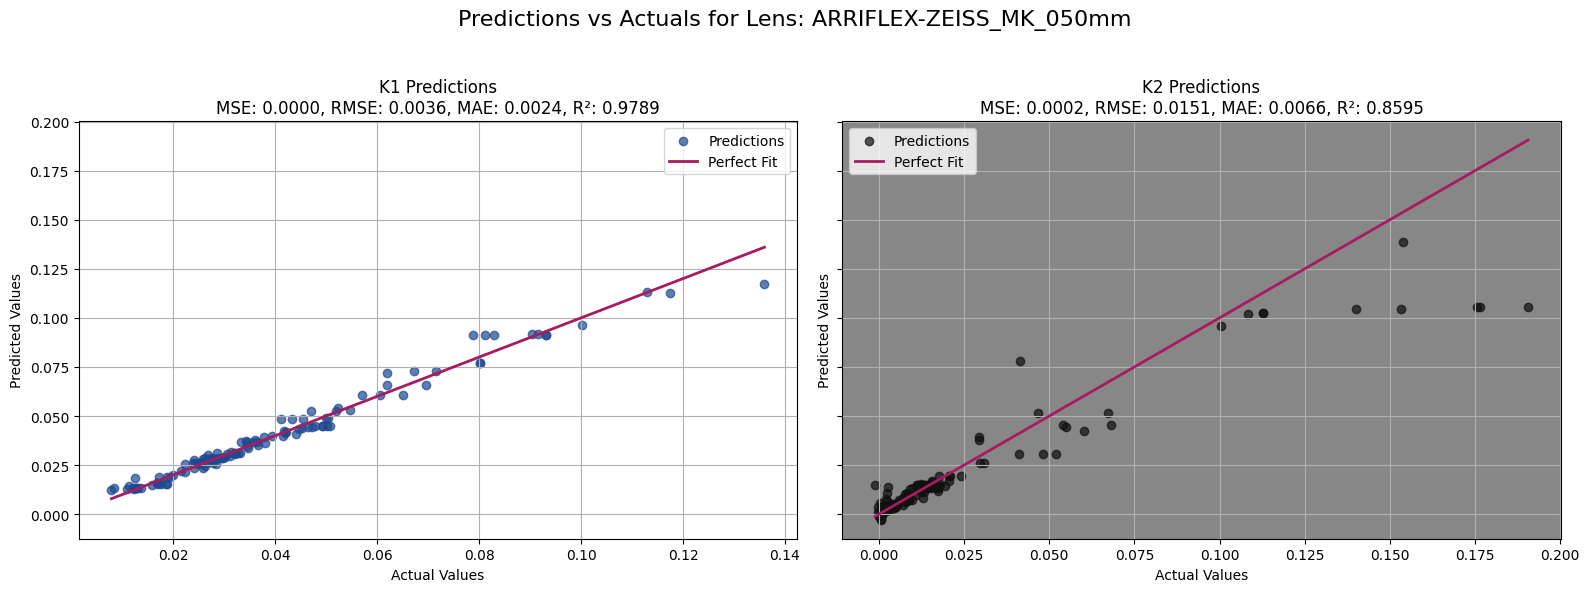

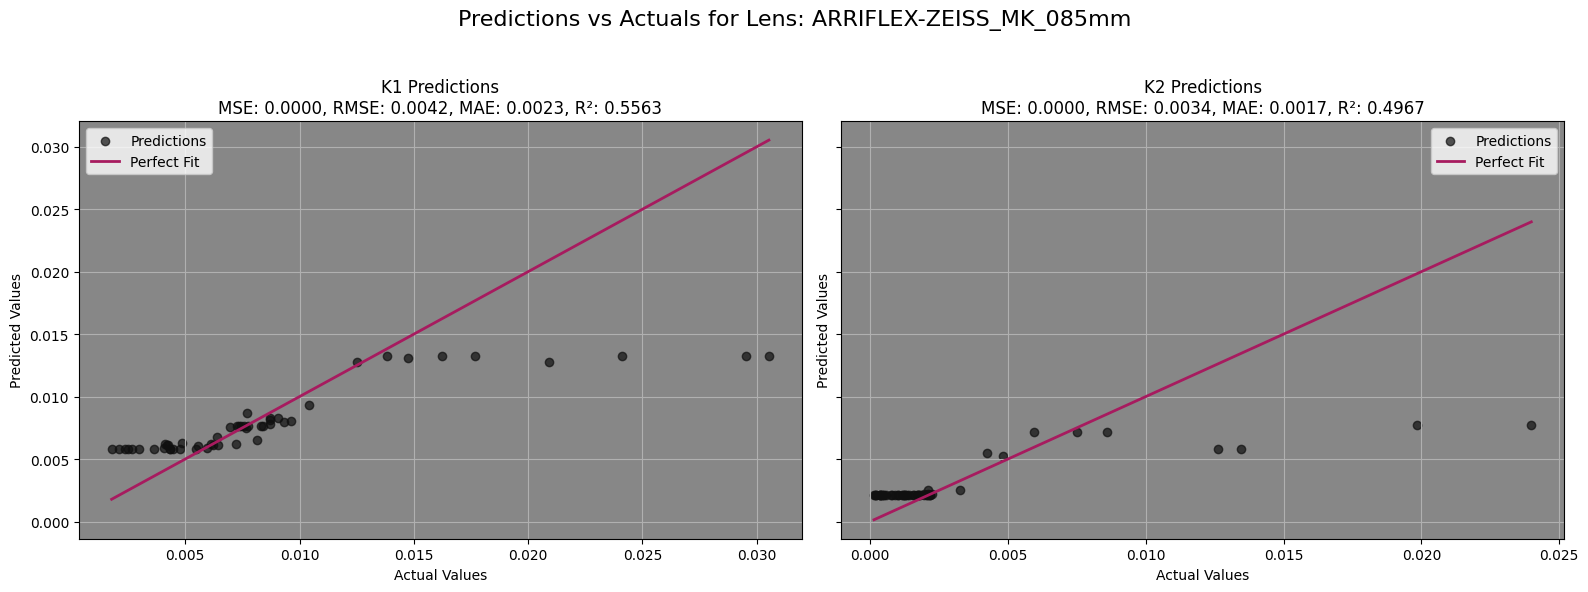

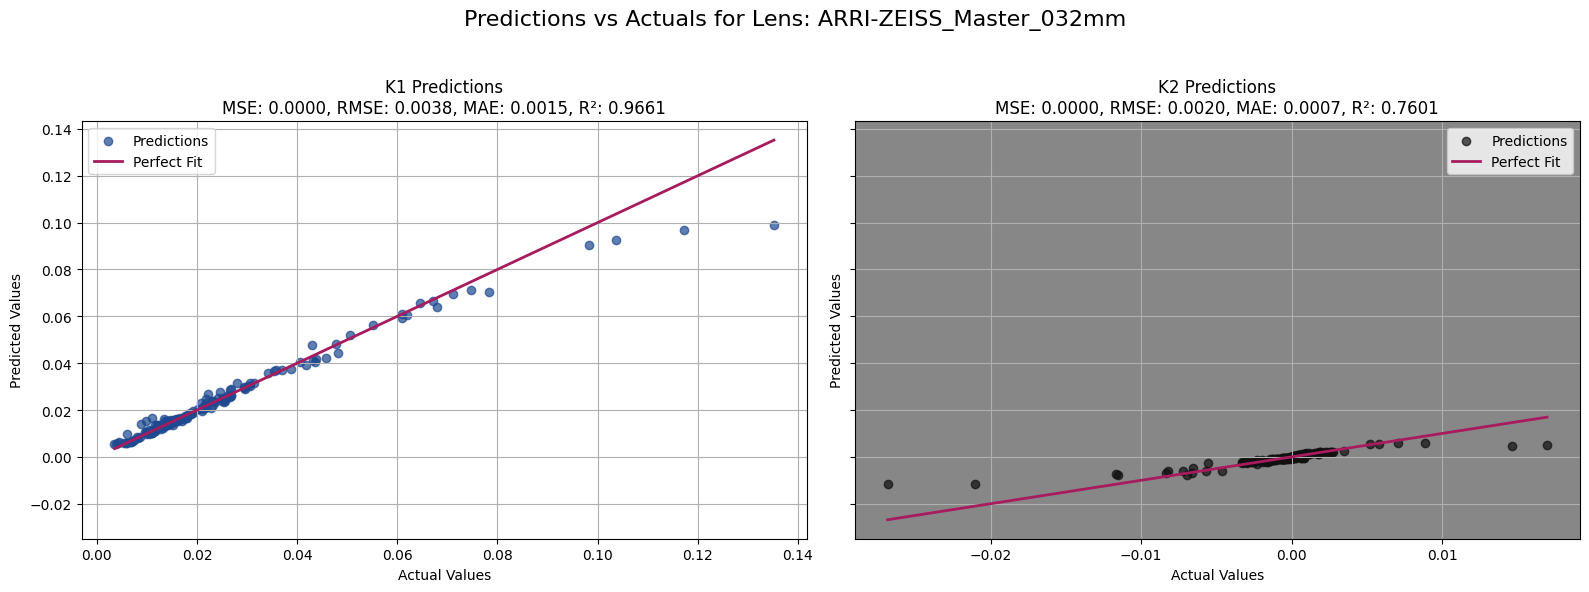

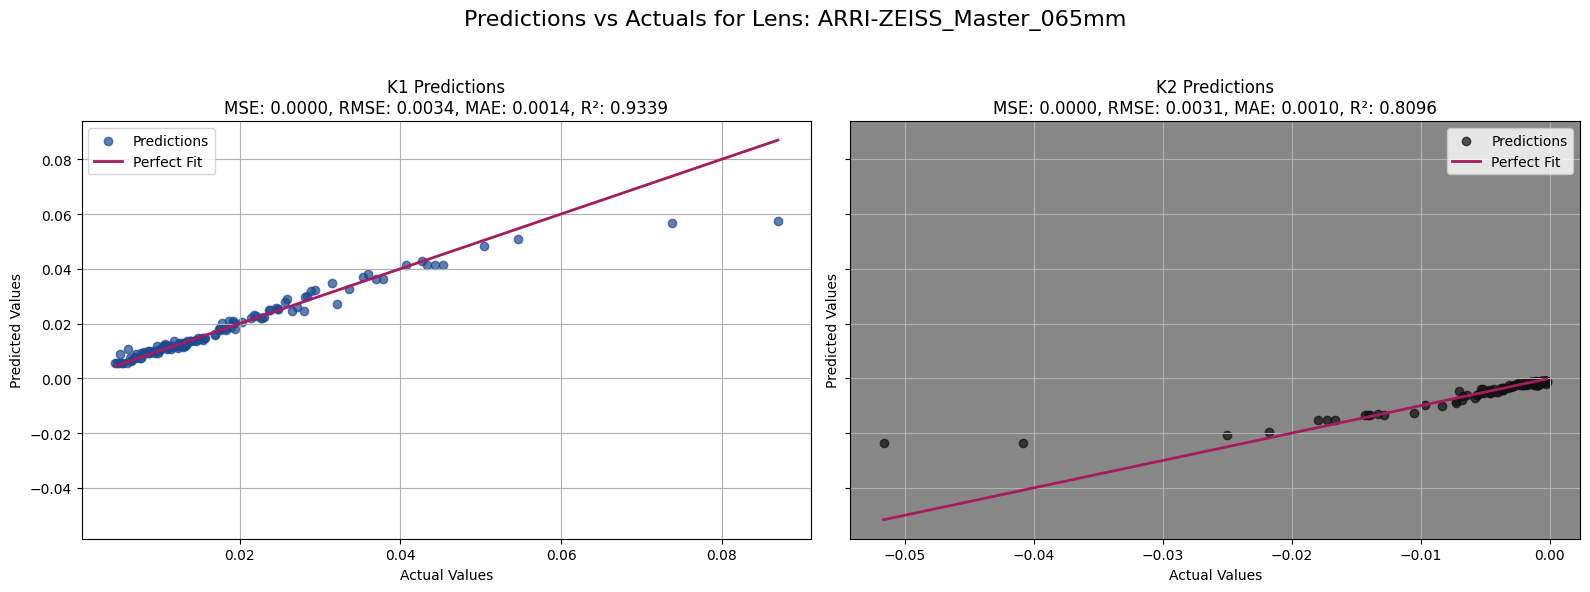

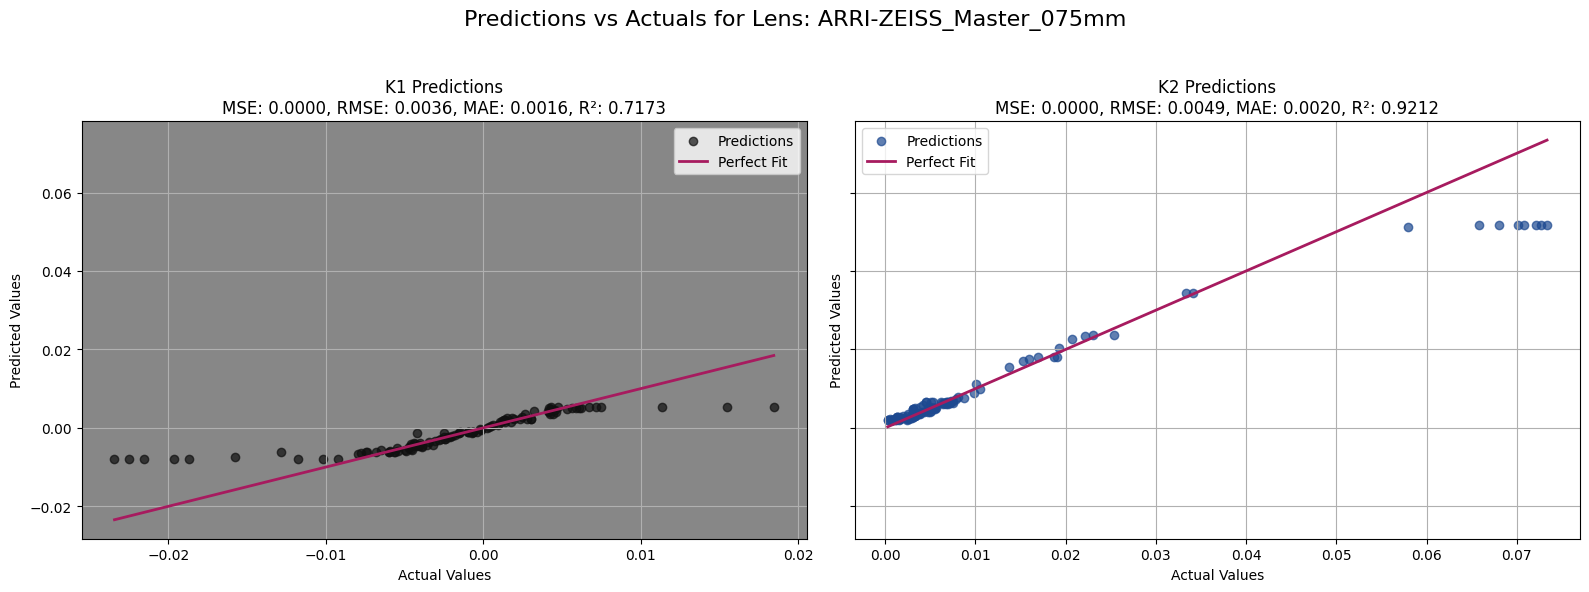

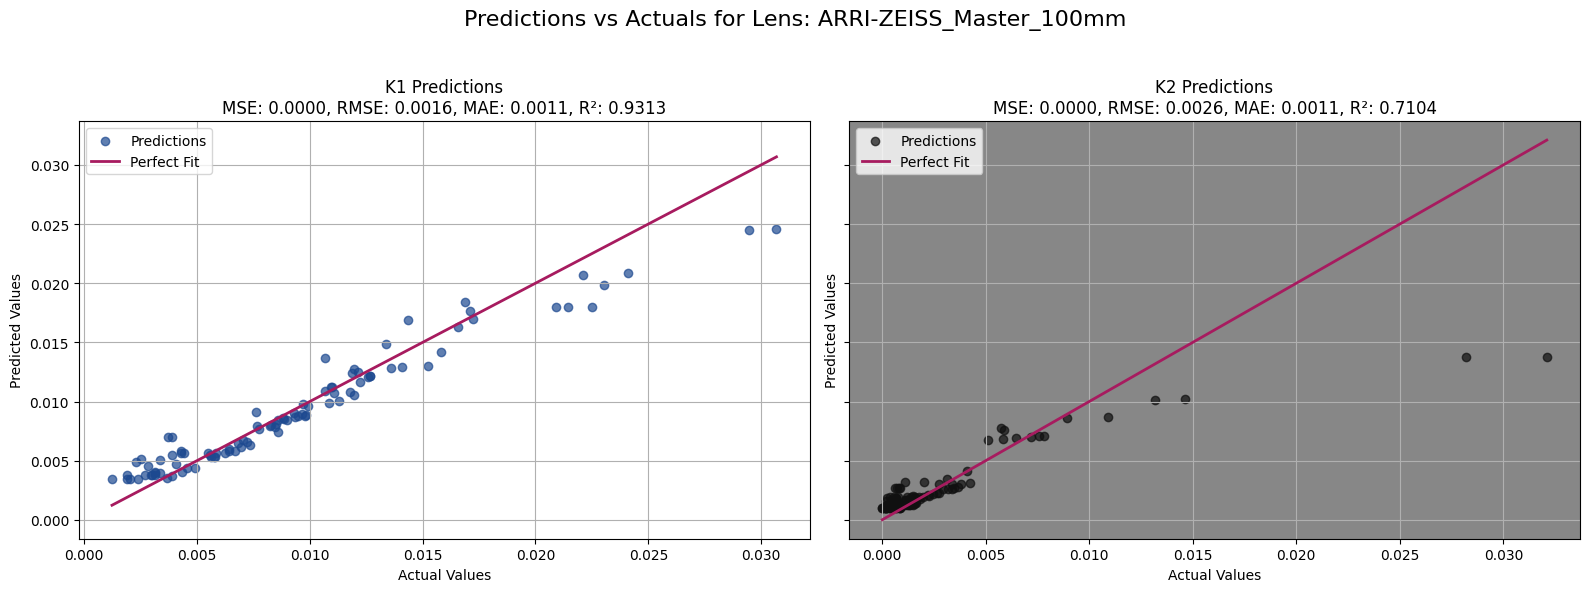

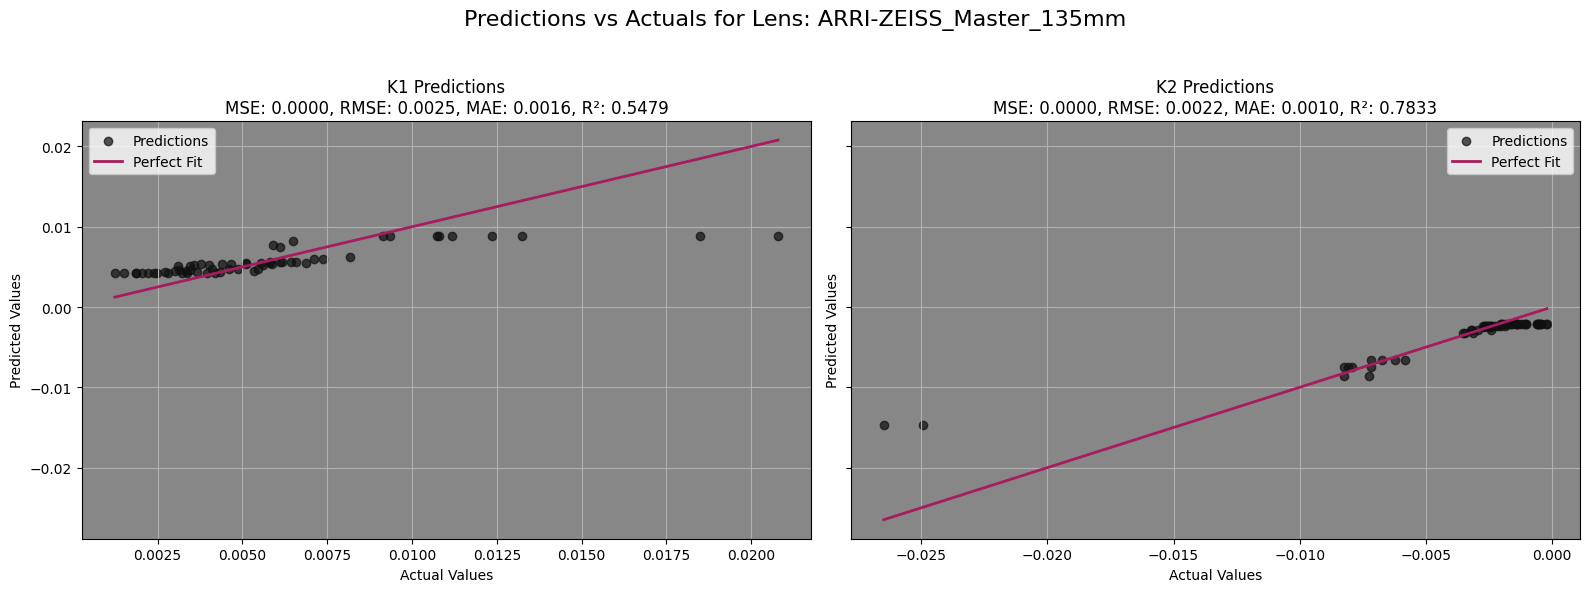

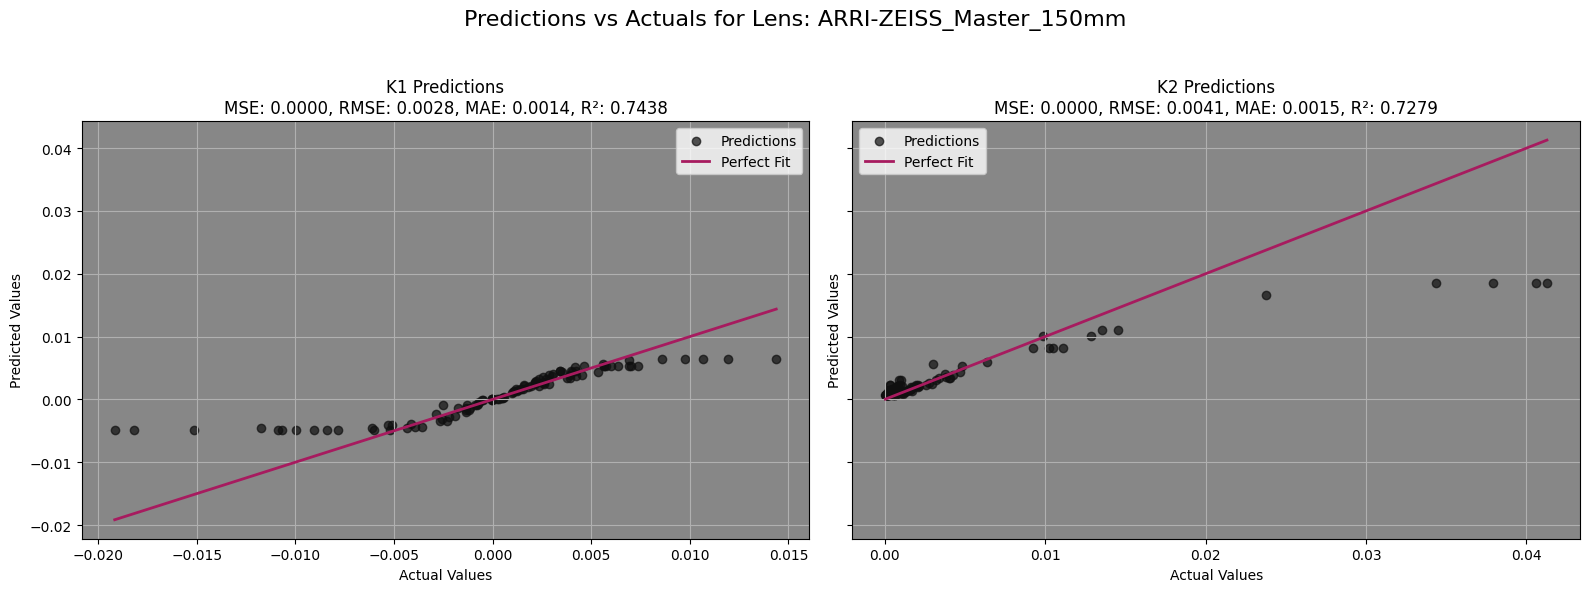

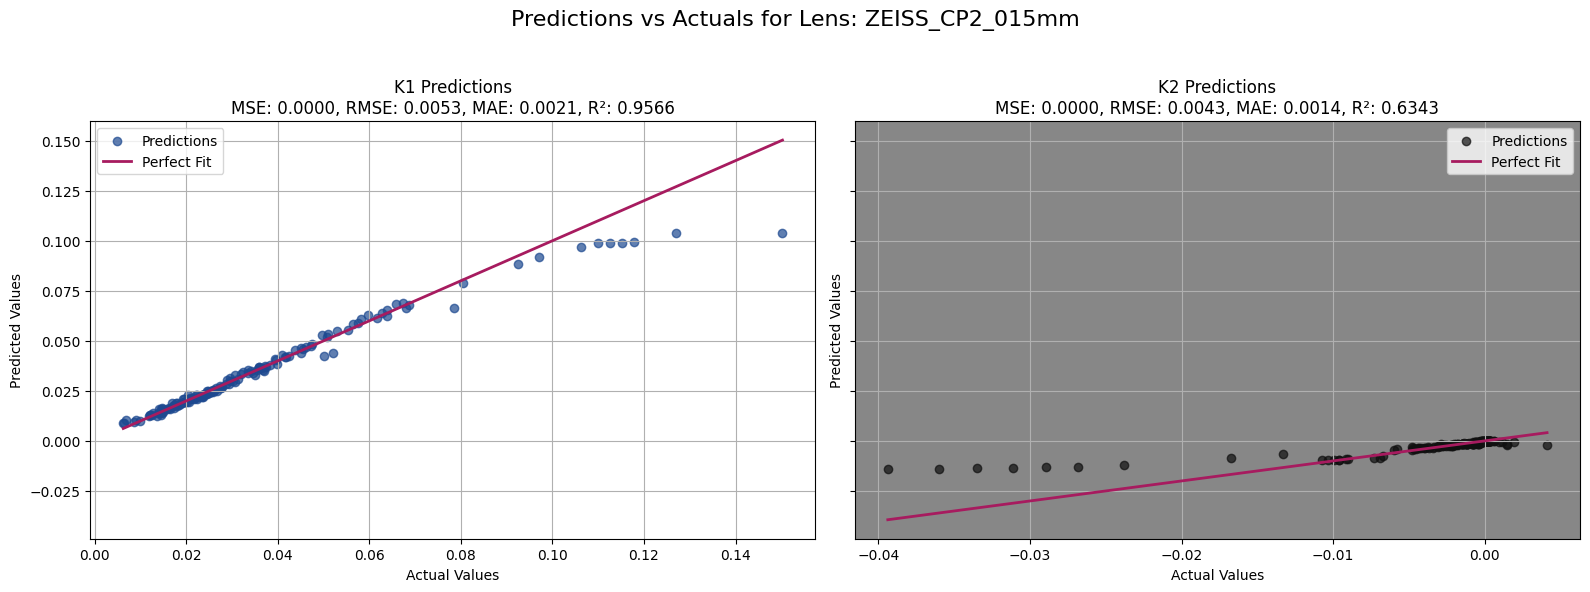

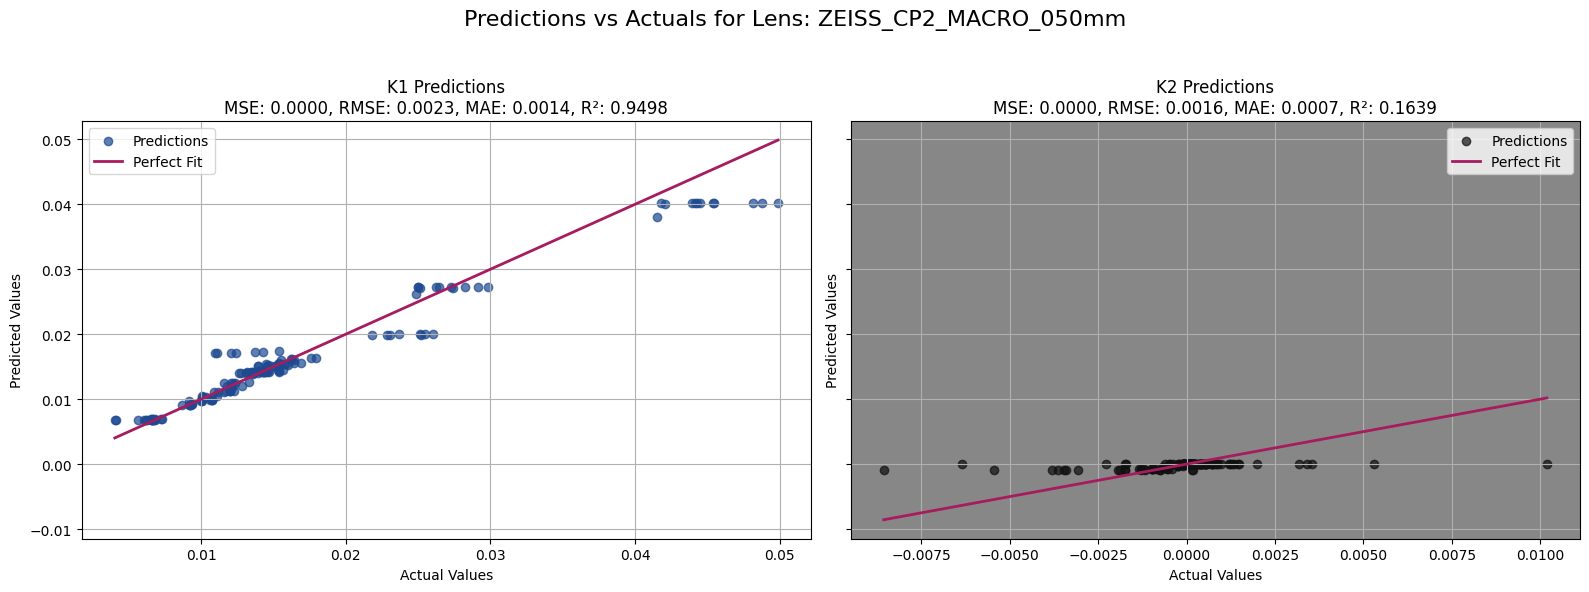

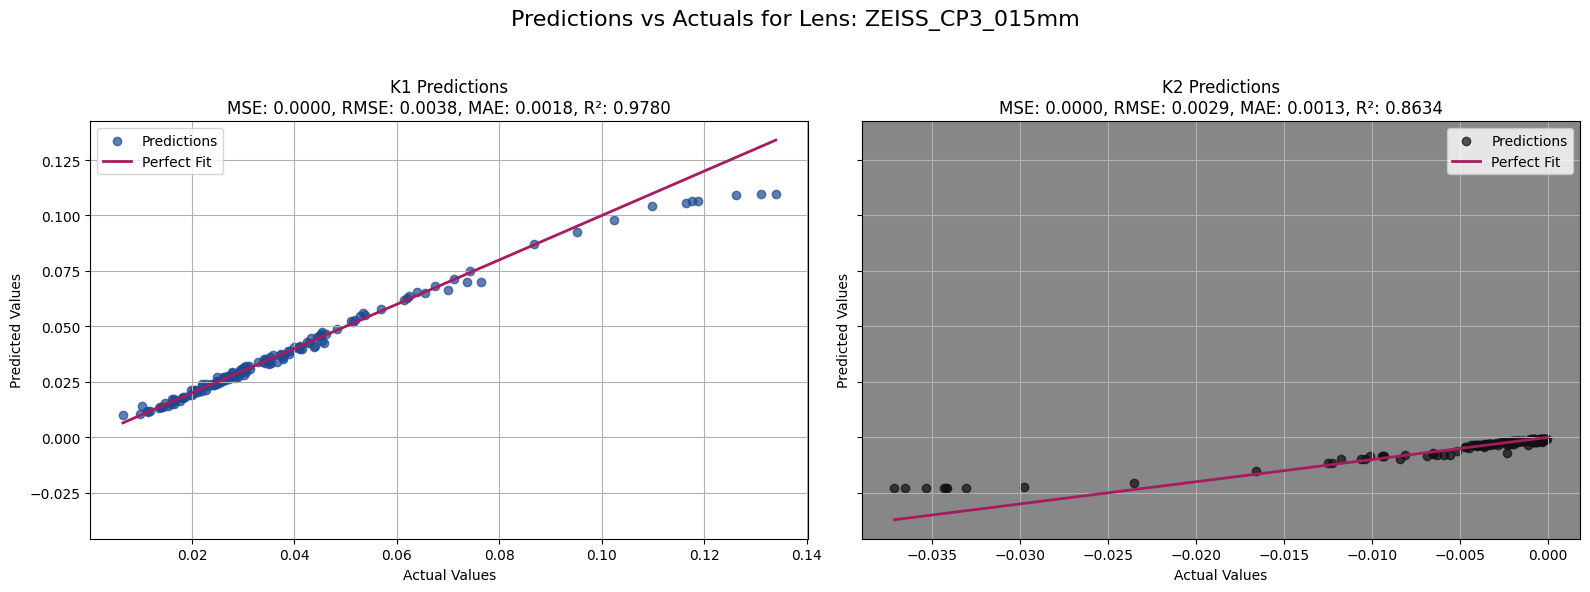

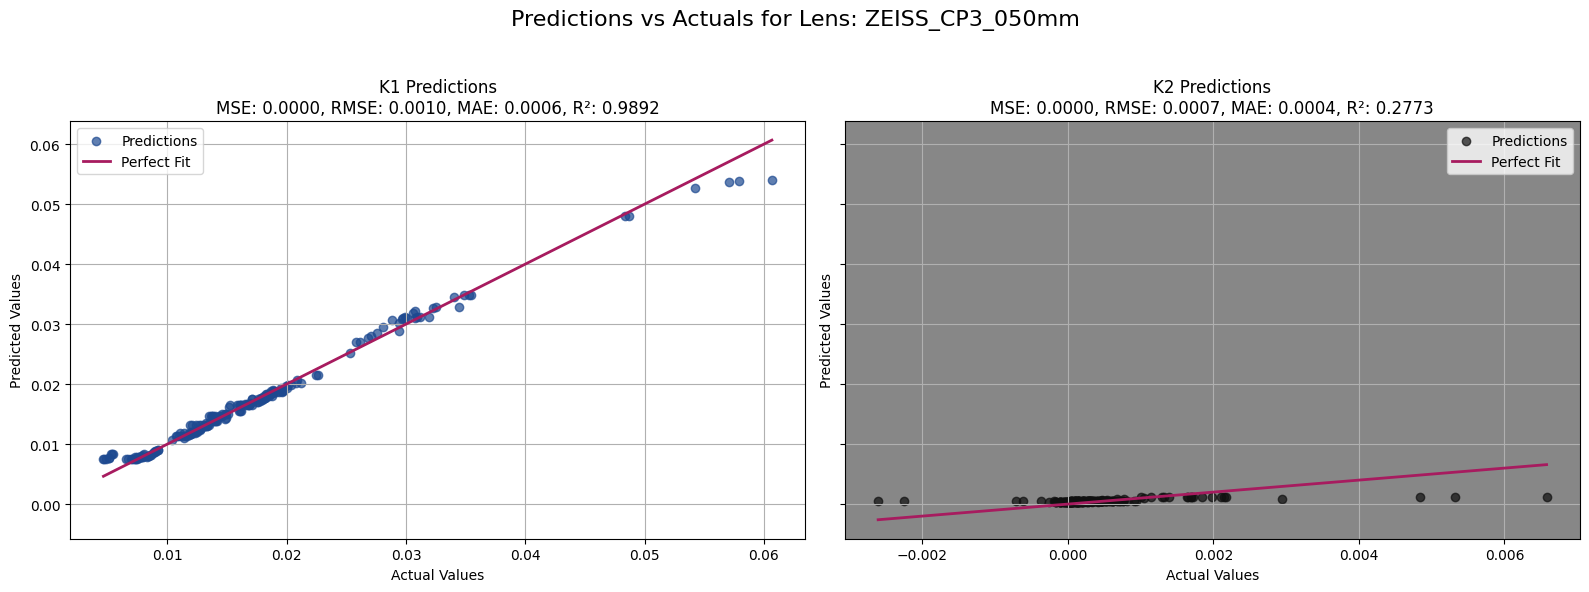

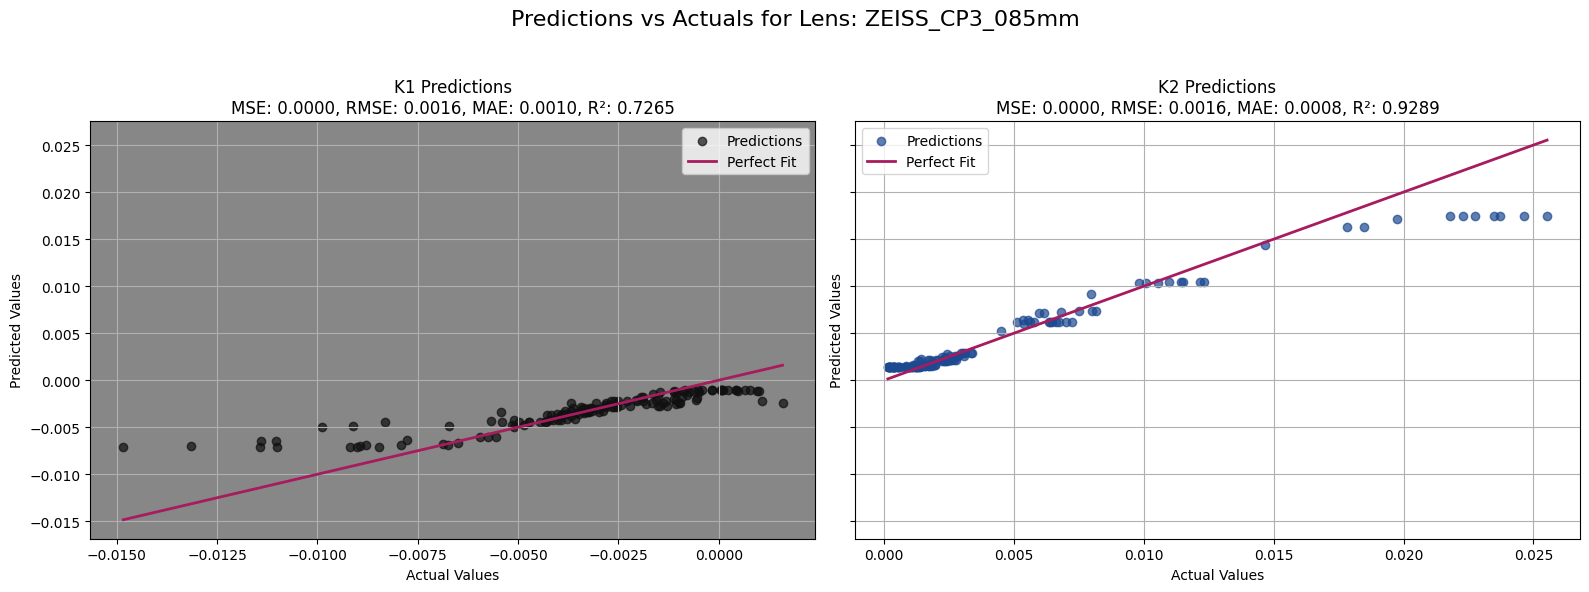

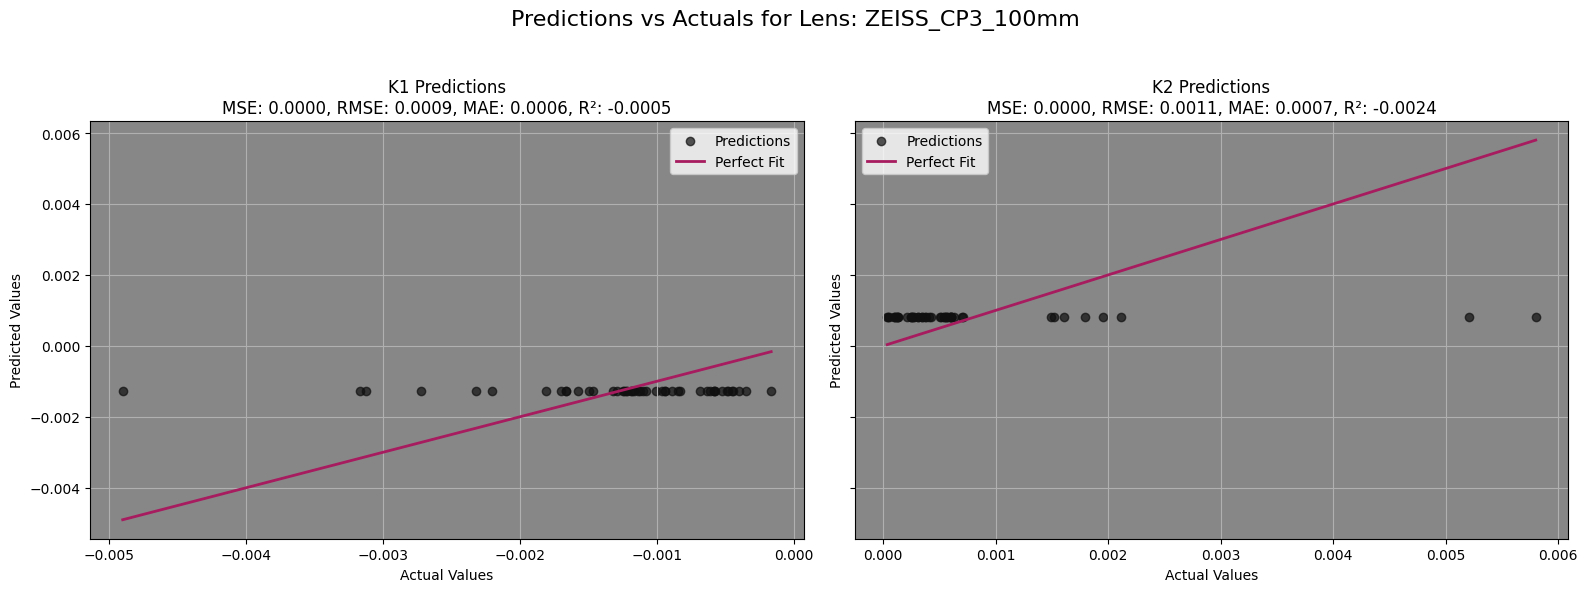

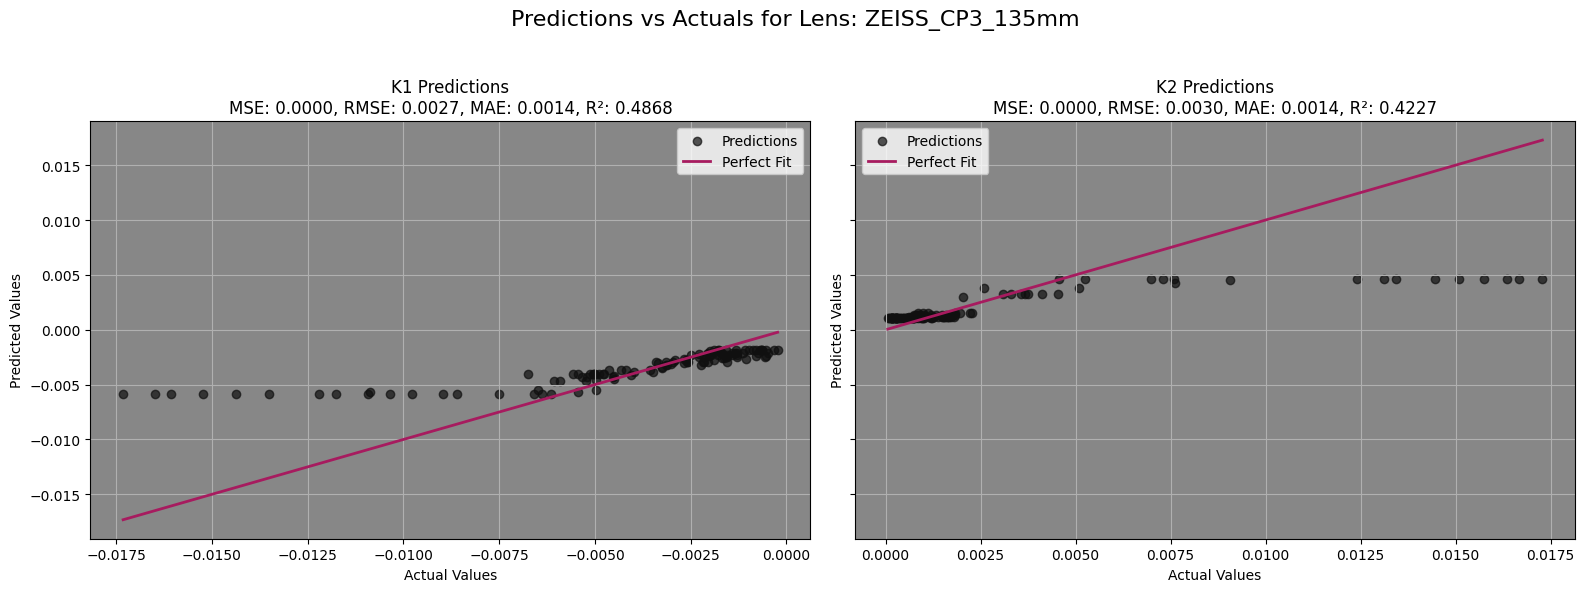

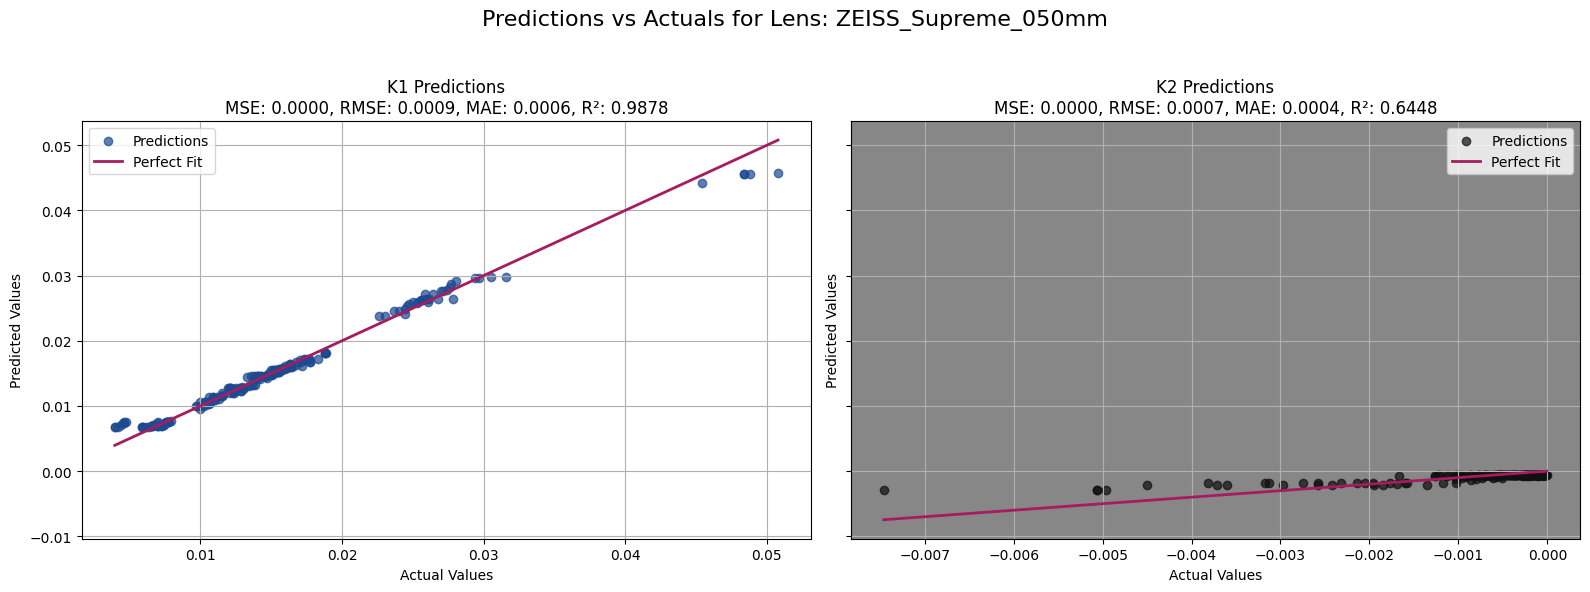

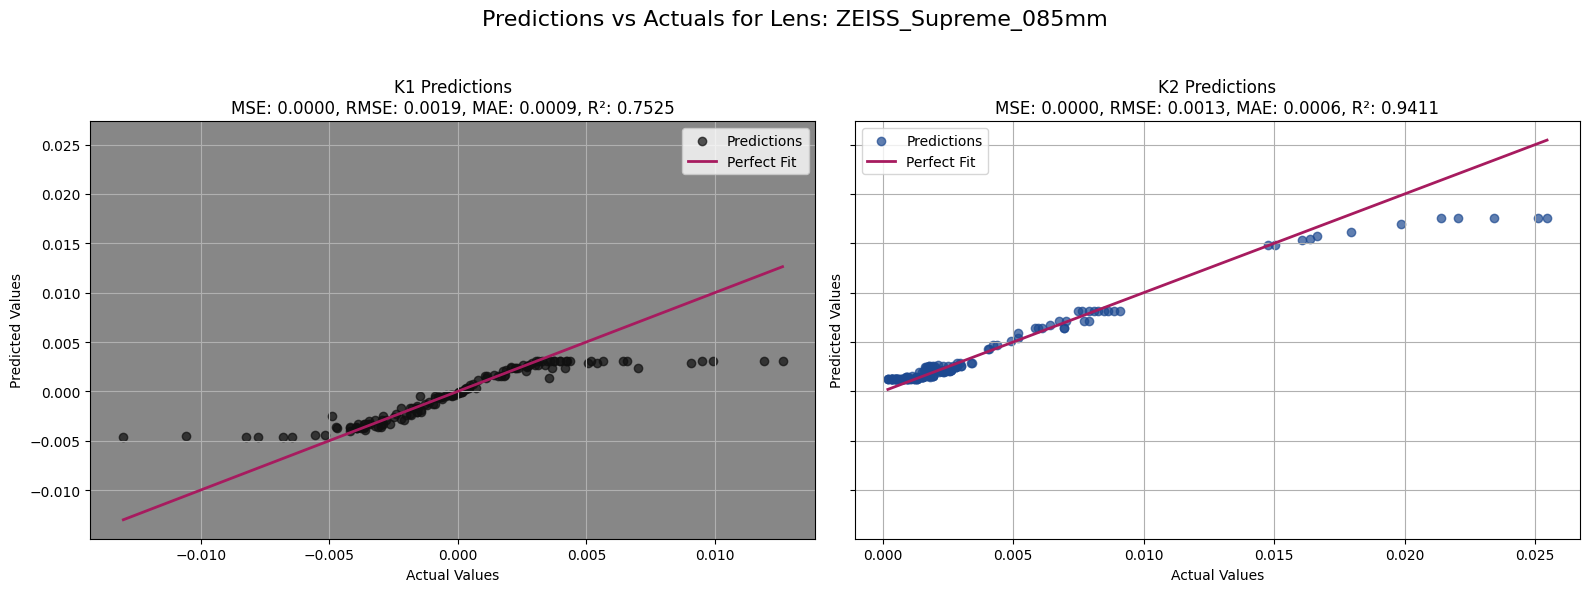

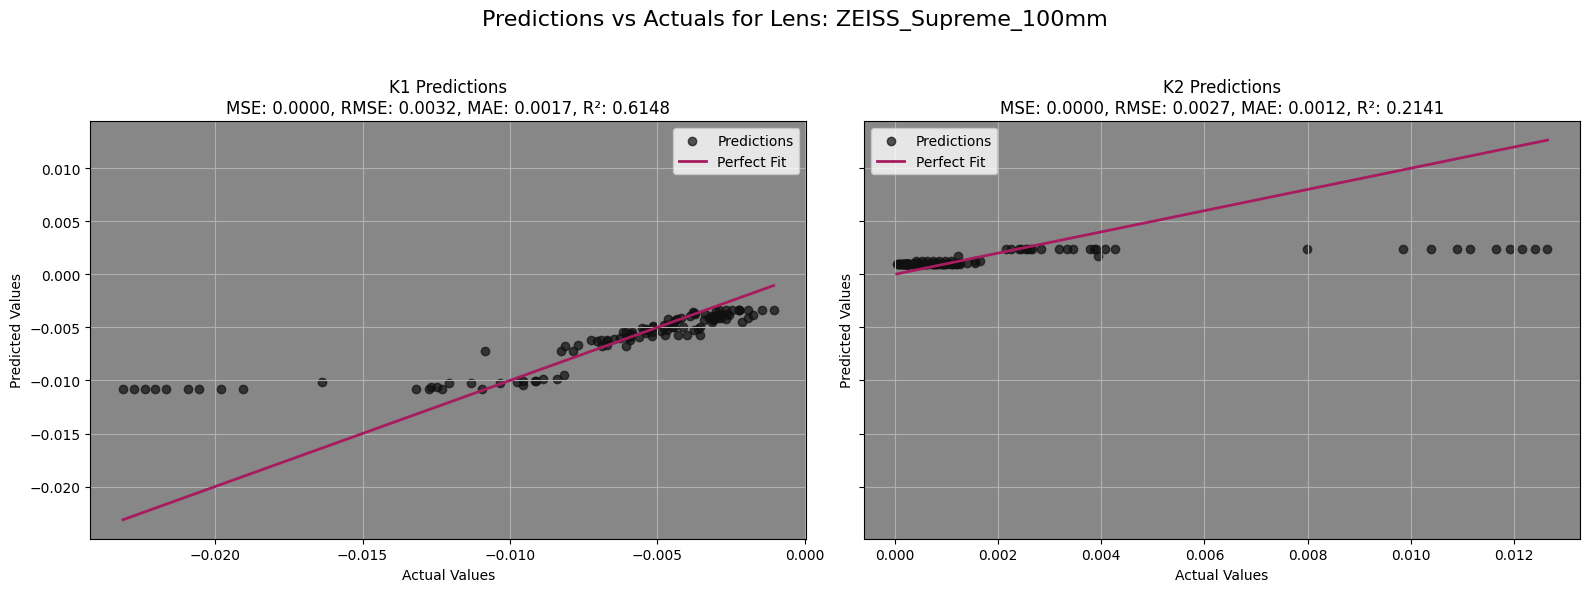

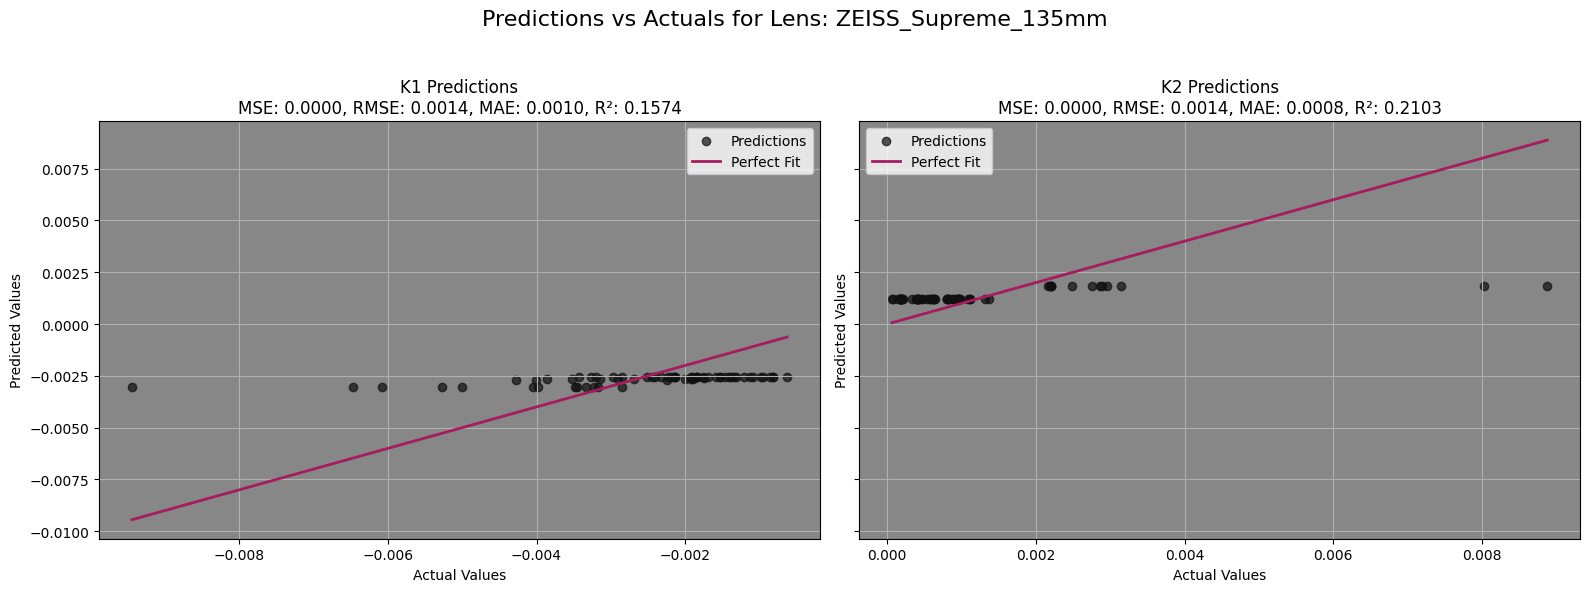

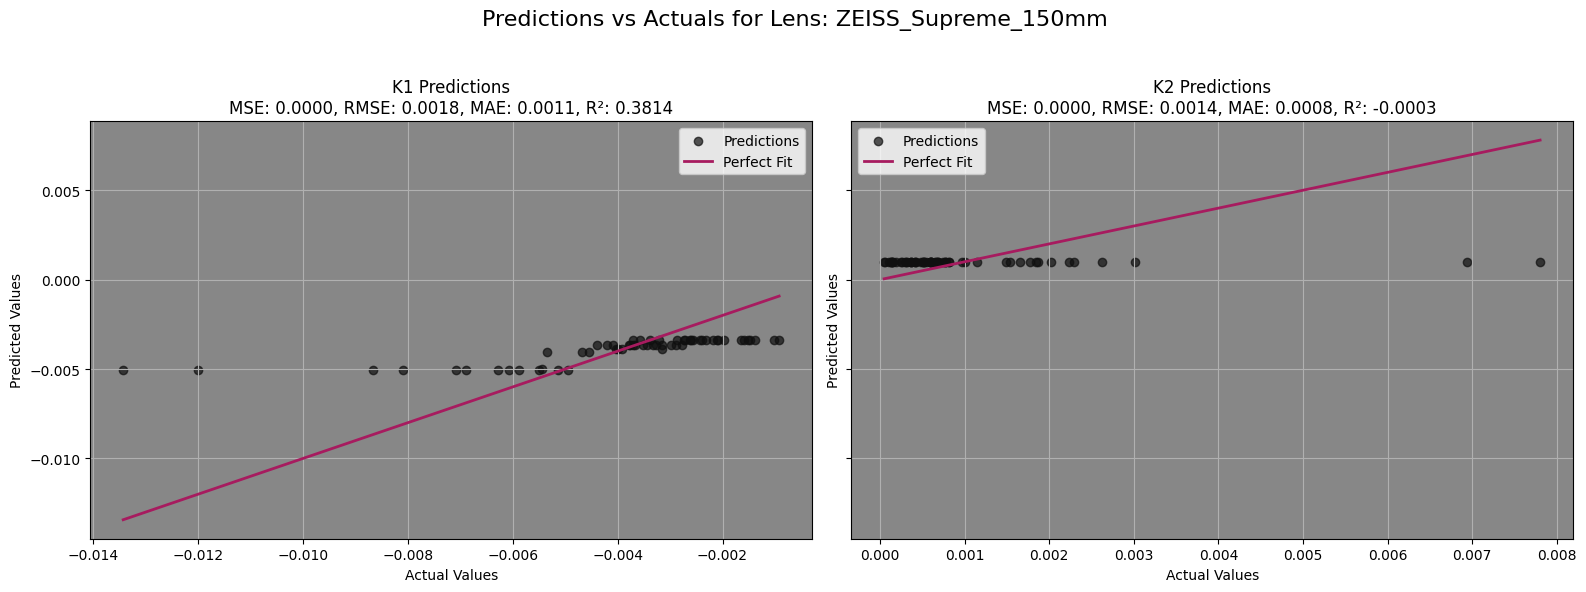

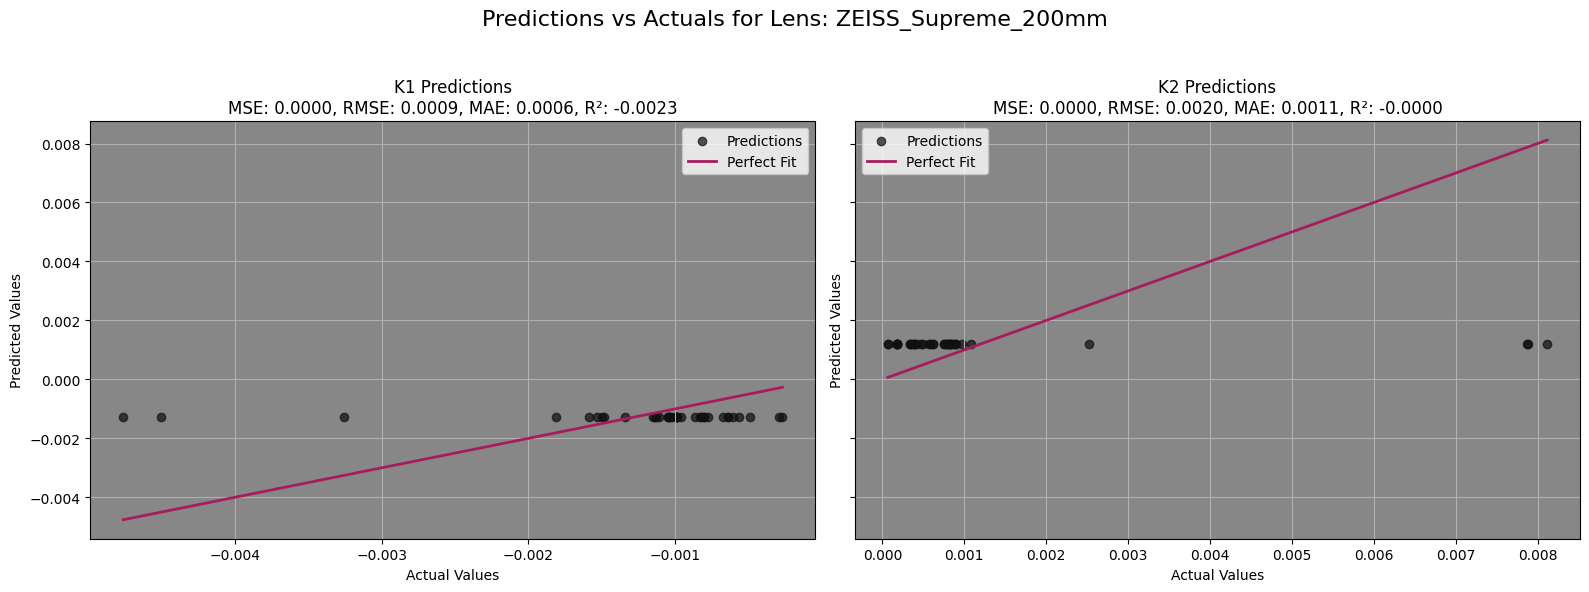

In [15]:
# Plot results for all lenses
for lens, y_test, predictions in lens_results:
    plot_results(y_test, predictions, lens_name=lens, r2_threshold=.9)